In [34]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
#from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import norm

import geopy.distance


plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 16})

# DJI and uBlox processing notebook
Annie Polish, August 2021

---
## Reading in a file

In [8]:
# define the directories
dji_csv_dir = "/hirax/all_drone_data/datcon_csv"
ublox_dir = "/hirax/all_drone_data/ublox"

22199
[Timedelta('-1 days +23:59:59.400000')
 Timedelta('-1 days +23:59:59.400000')
 Timedelta('-1 days +23:59:59.400000') ...
 Timedelta('-1 days +23:59:59.770501271')
 Timedelta('-1 days +23:59:59.770501271')
 Timedelta('0 days 00:00:00.199999')]
0          2021-07-30 18:34:55.199534+00:00
1          2021-07-30 18:34:55.399534+00:00
2          2021-07-30 18:34:55.599534+00:00
3          2021-07-30 18:34:55.799534+00:00
4       2021-07-30 18:34:56.429496683+00:00
                        ...                
22194      2021-07-30 19:36:34.599696+00:00
22195      2021-07-30 19:36:34.799695+00:00
22196   2021-07-30 19:36:35.429496699+00:00
22197      2021-07-30 19:36:35.199695+00:00
22198      2021-07-30 19:36:34.599696+00:00
Name: UTC, Length: 22199, dtype: datetime64[ns, UTC]
Index(['index', 'iTOW', 'tAcc', 'Lon', 'Lat', 'Height', 'HMSL', 'hAcc', 'vAcc',
       'pDOP', 'numSV', 'velN', 'velE', 'velD', 'gspeed', 'sAcc', 'headmot',
       'headAcc', 'fixType', 'fixOK', 'UTCvalid', 'HPvali

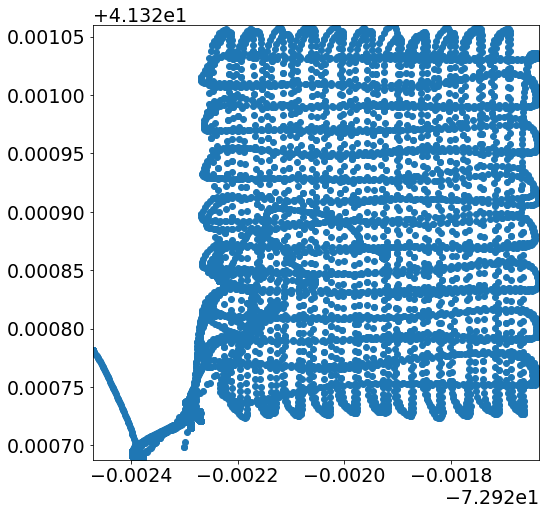

2021-07-30 18:34:55.199534+00:00


UFuncTypeError: ufunc 'true_divide' cannot use operands with types dtype('O') and dtype('<m8[s]')

<Figure size 576x576 with 0 Axes>

In [119]:
# read ublox files
df1 = pd.read_csv(ublox_dir+"/07301834",sep=",",header=0)
df2 = pd.read_csv(ublox_dir+"/07301902",sep=",",header=0)
df3 = pd.read_csv(ublox_dir+"/07301930",sep=",",header=0)

df = pd.concat([df1, df2, df3], ignore_index=True)

# turn the timestamps into real datetime objects
utc = pd.to_datetime(df.UTC)
print(len(utc))
diffs = np.diff(utc)
print(np.sort(np.diff(utc))[:5438])
df = df.assign(UTC = utc)
df = df.reset_index()
ubx_df = df.set_index('UTC')
ubx_df = ubx_df.assign(UTC = utc)
print(df.UTC)

print(ubx_df.columns)
    
# make a quick scatter plot
fig = plt.figure()
plt.scatter(ubx_df.Lon, ubx_df.Lat)
plt.xlim(min(ubx_df.Lon), max(ubx_df.Lon))
plt.ylim(min(ubx_df.Lat), max(ubx_df.Lat))
plt.show()

print(ubx_df.index[0])

fig = plt.figure()
plt.hist(diffs/np.timedelta64(1, 's'))
plt.show()


ubx_df.to_csv("./deb_ubx_out.csv")

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (107,142,143,144,145,146,147,148,149,150,151,364,366,368,369,1298,1389) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Interpolating time starting at 2021-07-30T19:20:12Z
Index(['Tick#', 'offsetTime', 'IMU_ATTI(0):Longitude', 'IMU_ATTI(0):Latitude',
       'IMU_ATTI(0):numSats', 'IMU_ATTI(0):barometer:Raw',
       'IMU_ATTI(0):barometer:Smooth', 'IMU_ATTI(0):accel:X',
       'IMU_ATTI(0):accel:Y', 'IMU_ATTI(0):accel:Z',
       ...
       'ahrs_data:ns_agx', 'ahrs_data:ns_agy', 'ahrs_data:ns_agz',
       'ahrs_data:ns_vgx', 'ahrs_data:ns_vgy', 'ahrs_data:ns_vgz',
       'Attribute|Value', 'ConvertDatV3', '3.6.6', 'timestamp'],
      dtype='object', length=1393)
2021-07-30 18:34:55.199534+00:00


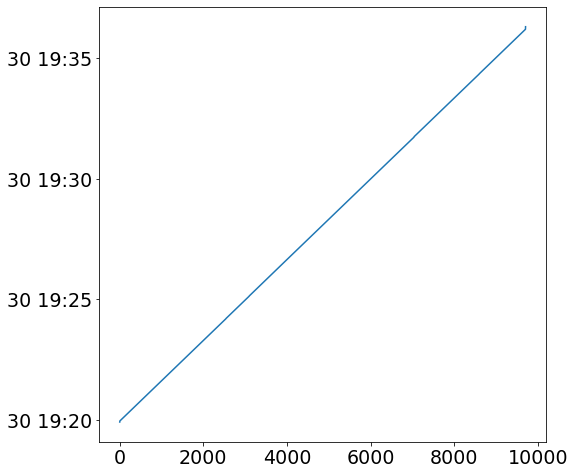

In [44]:
# read dji file
#df_in = pd.read_csv(dji_csv_dir+"/FLY458.csv")
df_in = pd.read_csv(dji_csv_dir+"/FLY460.csv")

# find where the GPS turns on
gps_idx = df_in[df_in.gpsUsed == True].index[0]

### NEW METHOD ###
# find the first datetimestamp after that
num_sv = df_in["GPS(0):numSV"][gps_idx]
# oops, maybe the GPS needs a minute to warm up
while(num_sv < 5 and gps_idx < len(df_in)-10):
    print("inc")
    gps_idx = gps_idx+1
    num_sv = df_in["GPS(0):numSV"][gps_idx]

first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
### END NEW METHOD ###

### OLD METHOD ###
# # find the first datetimestamp after that
# first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
# # oops, maybe the GPS needs a minute to warm up
# while(type(first_dts) == type(1.0) and gps_idx < len(df_in)-10):
#     print("inc")
#     gps_idx = gps_idx+1
#     first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
### END OLD METHOD ###

print("Interpolating time starting at "+str(first_dts))

# look for where the datetimestamp ticks
start_sec = int(first_dts[-3:-1])

while(int(df_in["GPS:dateTimeStamp"][gps_idx][-3:-1]) == start_sec):
    gps_idx = gps_idx + 1

# use this reference timestamp to convert the offsetTime column into proper datetimes
start_dt = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx])

offsets = np.array(df_in["offsetTime"]-df_in["offsetTime"][gps_idx])
offsets = pd.to_timedelta(offsets, unit='s')

timestamps = start_dt + offsets

# put them in the dataframe
df_in = df_in.assign(timestamp = timestamps)
dji_df = df_in.assign(UTC = timestamps)

plt.plot(dji_df.UTC)

# assign a datetime index
dji_df = dji_df.set_index('UTC')

print(dji_df.columns)
print(ubx_df.index[0])

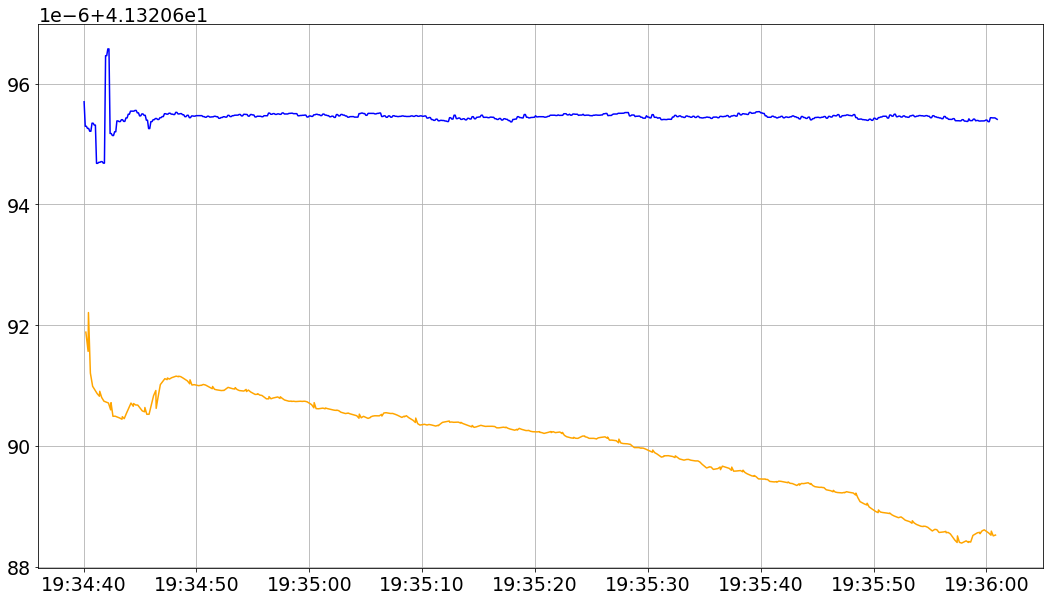

In [66]:
old_df = pd.read_csv("/hirax/all_drone_data/processed_csv/FLY458_old.csv")
old_df = old_df.assign(UTC = pd.to_datetime(old_df.UTC))
old_df = old_df.set_index('UTC')

ub_sort = ubx_df.sort_index()

start_t = "2021-07-30 19:34:40"
end_t = "2021-07-30 19:36:00"
fig = plt.figure(figsize=(18,10))
#plt.plot(ubx_df.Lat[start_t:end_t], c="g")
plt.plot(ub_sort.Lat[start_t:end_t], c="orange")
plt.plot(dji_df["RTKdata:Lat_P"][start_t:end_t], c="b")
plt.grid()
plt.show()

<ipython-input-60-0987c95cb97f>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lat_arr = ubx_df["Lat"][start_t:end_t].values
<ipython-input-60-0987c95cb97f>:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lon_arr = ubx_df["Lon"][start_t:end_t].values


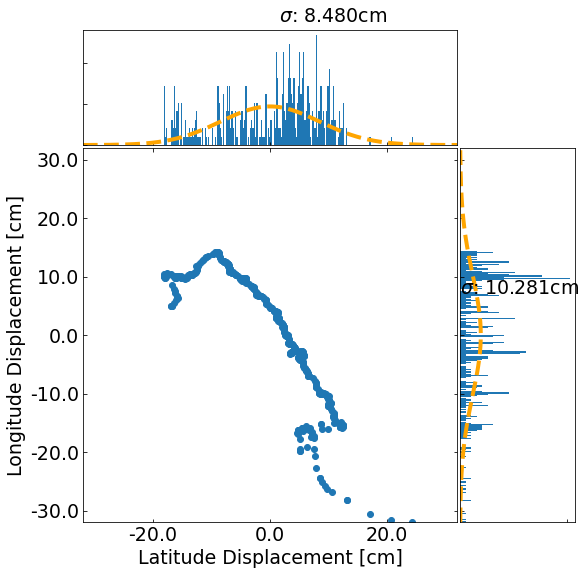

In [60]:
plt.rcParams.update({'font.size': 19})

lat_arr = ubx_df["Lat"][start_t:end_t].values
lon_arr = ubx_df["Lon"][start_t:end_t].values

# convert each of the latitude and longitude arrays into a displacement from mean, in meters
center_lat = np.mean(lat_arr)
center_lon = np.mean(lon_arr)
lat_disp, lon_disp = [], []
for lat in lat_arr:
    disp = geopy.distance.distance((center_lat, center_lon), (lat, center_lon)).m*100.
    if (lat < center_lat): disp = -1.*disp
    lat_disp.append(disp)
for lon in lon_arr:
    disp = geopy.distance.distance((center_lat, center_lon), (center_lat, lon)).m*100.
    if (lon < center_lon): disp = -1.*disp
    lon_disp.append(disp)    

x = lat_disp
y = lon_disp

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
label_gap = 0.02


rect_scatter = [label_gap+left, bottom, width, height]
rect_histx = [label_gap+left, bottom + height + spacing, width, 0.2]
rect_histy = [label_gap+left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False, labelleft=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False, labelbottom=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.2
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
#ax_scatter.yaxis.set_ticks([-0.5,0,0.5])
#ax_scatter.grid()


bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins, density=True)
ax_histy.hist(y, bins=bins, orientation='horizontal', density=True)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

# make and add gaussian fits
lat_mu, lat_sigma = norm.fit(lat_disp)
lon_mu, lon_sigma = norm.fit(lon_disp)
ax_histx.plot(bins, norm.pdf(bins, lat_mu, lat_sigma), '--', color='orange', linewidth=4)
ax_histy.plot(norm.pdf(bins, lon_mu, lon_sigma), bins, '--', color='orange', linewidth=4)
ax_histx.text(1.5, 0.15, "$\sigma$: %.3fcm"%lat_sigma)
ax_histy.text(0., 7, "$\sigma$: %.3fcm"%lon_sigma)

# LABELS LABELS LABELS
ax_scatter.set_xlabel("Latitude Displacement [cm]")
ax_scatter.set_ylabel("Longitude Displacement [cm]")

plt.show()

## Column descriptions
* **iTOW**: GPS time of week in milliseconds
* **UTC**: UTC timestamp
* **tAcc**: Time accuracy estimate in nanoseconds
* **Lon**: Longitude in decimal degrees
* **Lat**: Latitude in decimal degrees
* **Height**: Height above the WGS84 ellipsoid in meters
* **HMSL**: Height above mean sea level in meters
* **hAcc**: Horizontal accuracy estimate in millimeters
* **vAcc**: Vertical accuracy estimate in millimeters
* **pDOP**: Position dilution of precision * 100 (unitless measurement of the quality of the current arrangement of satellites overhead)
* **numSV**: Number of satellites currently connected
* **velN, velE, velD**: Velocity in mm/s in NED coordinates
* **gspeed**: 2D ground speed in mm/s
* **headmot**: Heading of motion (note that this is from GPS only, not an IMU, and is not very accurate)
* **sAcc**: Speed accuracy estimate in mm/s
* **headAcc**: Heading accuracy estimate in degrees
* **fixType**: 0 for no fix, 1 for dead-reckoning, 2 for 2D fix, 3 for 3D fix, 4 for GNSS+dead reckoning, 5 for time-only. The ideal value is 3.
* **fixOK**: 1 if the fix is "OK", 0 if not. 
* **UTCvalid**: 1 if the time and date are confirmed to be correct, 0 if not
* **HPvalid**: 1 if the high precision fix if "OK", 0 if not
* **carrierSoln**: 2 if carrier phase ambiguities are fixed, 1 if they're floating, 0 if not corrected. 2 is ideal.
* **diffCorrected**: 1 if differential corrections have been applied, 0 if not

## Plots

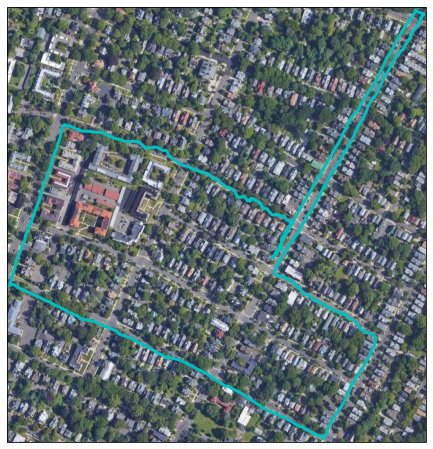

In [84]:
# Plot the data against a variety of basemaps

# choose a plot background
#PLOT_BG = cimgt.Stamen('toner') # black&white lines with street names
#PLOT_BG = cimgt.Stamen('toner-background') # same as toner but no names
#PLOT_BG = cimgt.Stamen('toner-lite') # same as toner but lighter/lower contrast
#PLOT_BG = cimgt.OSM() # open street map
#PLOT_BG = cimgt.GoogleTiles(style='street') # google maps
PLOT_BG = cimgt.GoogleTiles(style='satellite') # google earth
BORDER = 0.00005

fig = plt.figure()

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# set the extents of the plot to be a box around the data
ax.set_extent([min(df.Lon)-BORDER, max(df.Lon)+BORDER, min(df.Lat)-BORDER, max(df.Lat)+BORDER], crs=ccrs.Geodetic())

# use cartopy to add a satellite map to the background
ax.add_image(PLOT_BG, 17) # the number here sets the zoom level (0 is far, 20 is very zoomed in)

# plot the data, transformed into the coordinate system of our plot
plt.plot(df.Lon, df.Lat, 'c', linewidth=3, transform=ccrs.Geodetic(), label="GPS")

# label and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("groundtrack.png")
plt.show()



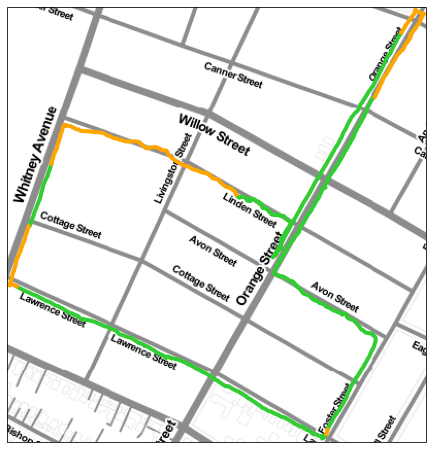

In [85]:
# Visualize the flag columns by conditionally coloring the plot

PLOT_BG = cimgt.Stamen('toner-lite')

BORDER = 0.00005

fig = plt.figure()

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# set the extents of the plot to be a box around the data
ax.set_extent([min(df.Lon)-BORDER, max(df.Lon)+BORDER, min(df.Lat)-BORDER, max(df.Lat)+BORDER], crs=ccrs.Geodetic())

# use cartopy to add a satellite map to the background
#ax.add_image(PLOT_BG, 20, interpolation='spline36')
ax.add_image(PLOT_BG, 16)

# plot the data, transformed into the coordinate system of our plot
df_diff = df.where(df.diffCorrected == 2)
df_nodiff = df.where(df.diffCorrected == 0)
plt.plot(df_diff.Lon, df_diff.Lat, 'c', linewidth=4, transform=ccrs.Geodetic(), label="GPS", color='limegreen')
plt.plot(df_nodiff.Lon, df_nodiff.Lat, 'c', linewidth=4, transform=ccrs.Geodetic(), label="GPS", color='orange')

# label and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("RTK_status.png")
plt.show()


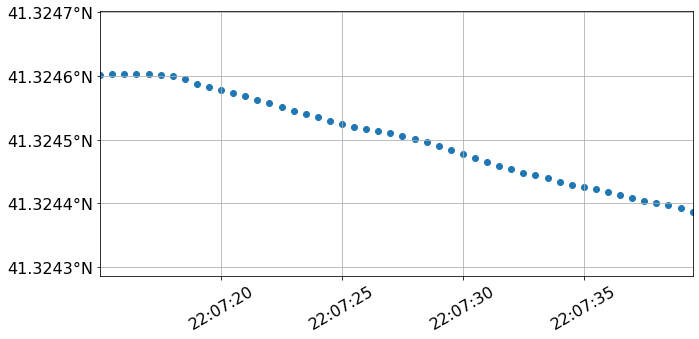

In [89]:
# Plot a variable over time
# This time I picked Latitude, but the process is the same for any of them

fig = plt.figure(figsize=(10,5))
ax = plt.gca()

# Format the timestamp on the x axis as HH:MM:SS
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()

# Uncomment this line to format a latitude axis
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)

# Uncomment this line to format a longitude axis 
#ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)

trim_start = 750
trim_stop = 800
plt.scatter(df[trim_start:trim_stop].UTC, df[trim_start:trim_stop].Lat)
plt.grid()
plt.xlim(min(df[trim_start:trim_stop].UTC),max(df[trim_start:trim_stop].UTC))
plt.ylim(min(df[trim_start:trim_stop].Lat)-0.0001,max(df[trim_start:trim_stop].Lat)+0.0001)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
